<a href="https://colab.research.google.com/github/RICHAR-SL/IA/blob/main/Examen_Practico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***EXAMEN PRACICO***

In [126]:
# Instalar librerías necesarias (ejecutar solo una vez)
# !pip install kaggle
# !pip install nltk
# !pip install tensorflow
# !pip install scikit-learn
# !pip install seaborn
# !pip install pandas numpy matplotlib


In [127]:
#  Importación de Librerías y Configuración Inicial

# Métricas adicionales
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importar todas las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from datetime import datetime, timedelta


# Configuraciones iniciales
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Descargar recursos de NLTK
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

print("✅ Librerías importadas y configuradas correctamente")
print(f"🔢 TensorFlow versión: {tf.__version__}")
print(f"🐼 Pandas versión: {pd.__version__}")
print(f"🔬 Scikit-learn disponible")


# - Importa todas las librerías de análisis de datos, ML y visualización
# - Configura el estilo visual de los gráficos
# - Descarga recursos necesarios para análisis de texto (NLTK)
# - Verifica que todo esté instalado correctamente


✅ Librerías importadas y configuradas correctamente
🔢 TensorFlow versión: 2.19.0
🐼 Pandas versión: 2.2.2
🔬 Scikit-learn disponible


In [128]:

# Generación de Datos(en español)


def generar_datos_financieros(n_muestras=255):
    np.random.seed(42)  # Para reproducibilidad

    # Generar fechas
    fecha_inicio = datetime(2020, 11, 7)
    fechas = [fecha_inicio + timedelta(days=i) for i in range(n_muestras)]

    # Generar precio base con tendencia
    precio_base = 10
    tendencia = np.linspace(0, 20, n_muestras)  # Tendencia alcista gradual
    ruido = np.random.normal(0, 5, n_muestras)  # Ruido aleatorio

    # Precio de cierre con componente de series temporales
    precios_cierre = []
    precio_actual = precio_base

    for i in range(n_muestras):
        # Añadir componente de momentum
        momentum = 0.7 if i > 0 else 0
        variacion_precio = (
            tendencia[i] / n_muestras
            + ruido[i]
            + momentum * (precios_cierre[i-1] - precio_base if i > 0 else 0) * 0.01
        )
        precio_actual = max(precio_actual + variacion_precio, 2.95)  # Precio mínimo de 2.95
        precios_cierre.append(precio_actual)

    # Crear DataFrame
    datos = pd.DataFrame({
        'Fecha': fechas,
        'Cierre': precios_cierre
    })

    # Generar Apertura, Máximo, Mínimo basados en Cierre
    datos['Apertura'] = datos['Cierre'].shift(1).fillna(datos['Cierre'].iloc[0]) + np.random.normal(0, 1, n_muestras)
    datos['Máximo'] = np.maximum(datos[['Apertura', 'Cierre']].max(axis=1) + np.random.exponential(2, n_muestras),
                                datos[['Apertura', 'Cierre']].max(axis=1))
    datos['Mínimo'] = np.minimum(datos[['Apertura', 'Cierre']].min(axis=1) - np.random.exponential(2, n_muestras),
                                datos[['Apertura', 'Cierre']].min(axis=1))

    # Otros
    datos['Volumen'] = np.random.randint(1_000_000, 10_000_000, n_muestras)
    datos['Capitalización_Bursátil'] = datos['Cierre'] * np.random.randint(1_000_000, 5_000_000, n_muestras)
    datos['Relación_P/E'] = np.random.normal(15, 5, n_muestras).clip(5, 50)
    datos['Rendimiento_Dividendo'] = np.random.normal(2.5, 1.2, n_muestras).clip(0, 10)

    return datos

# Generar el dataset
print("📊 Generando datos en español...")
datos_restaurant = generar_datos_financieros(500)

print(f"✅ Dataset generado con {len(datos_restaurant)} registros")
print("\n📋 Primeras 5 filas:")
print(datos_restaurant.head())




📊 Generando datos en español...
✅ Dataset generado con 500 registros

📋 Primeras 5 filas:
       Fecha     Cierre   Apertura     Máximo     Mínimo  Volumen  \
0 2020-11-07  12.483571  13.409748  13.776351   9.963730  2369277   
1 2020-11-08  11.809714  14.392987  14.613885  11.660086  6522567   
2 2020-11-09  15.060985  10.411147  17.084554  10.263301  7722090   
3 2020-11-10  22.711802  15.623955  25.163392  15.599590  1749971   
4 2020-11-11  21.630338  22.061160  22.125351  15.360285  9222502   

   Capitalización_Bursátil  Relación_P/E  Rendimiento_Dividendo  
0             1.670757e+07     16.036337               2.155063  
1             2.214926e+07     15.346722               2.844795  
2             3.883196e+07     11.391312               2.445385  
3             9.613692e+07     15.884104               1.990916  
4             6.552141e+07     12.266600               1.816200  


In [129]:
#  Preprocesamiento y Creación de Indicadores Técnicos

# Función para calcular indicadores técnicos
def calculate_technical_indicators(df):
    data = df.copy()

    # 1. Cambios de precio
    data['Cambio_Precio'] = data['Cierre'] - data['Apertura']
    data['Cambio_Precio_Pct'] = ((data['Cierre'] - data['Apertura']) / data['Apertura']) * 100
    data['Retorno_Diario'] = data['Cierre'].pct_change() * 100

    # 2. Volatilidad
    data['Volatilidad'] = ((data['Máximo'] - data['Mínimo']) / data['Cierre']) * 100
    data['Rango_Verdadero'] = np.maximum(
        data['Máximo'] - data['Mínimo'],
        np.maximum(
            abs(data['Máximo'] - data['Cierre'].shift(1)),
            abs(data['Mínimo'] - data['Cierre'].shift(1))
        )
    )

    # 3. Medias móviles
    data['MM_5'] = data['Cierre'].rolling(window=5).mean()
    data['MM_10'] = data['Cierre'].rolling(window=10).mean()
    data['MM_20'] = data['Cierre'].rolling(window=20).mean()
    data['MM_50'] = data['Cierre'].rolling(window=50).mean()

    # 4. RSI (Relative Strength Index)
    def calcular_rsi(precios, periodo=14):
        delta = precios.diff()
        ganancia = (delta.where(delta > 0, 0)).rolling(window=periodo).mean()
        perdida = (-delta.where(delta < 0, 0)).rolling(window=periodo).mean()
        rs = ganancia / perdida
        rsi = 100 - (100 / (1 + rs))
        return rsi

    data['RSI'] = calcular_rsi(data['Cierre'])

    # 5. MACD (Moving Average Convergence Divergence)
    exp1 = data['Cierre'].ewm(span=12).mean()
    exp2 = data['Cierre'].ewm(span=26).mean()
    data['MACD'] = exp1 - exp2
    data['MACD_Senal'] = data['MACD'].ewm(span=9).mean()
    data['MACD_Histograma'] = data['MACD'] - data['MACD_Senal']

    # 6. Bandas de Bollinger
    data['BB_Centro'] = data['Cierre'].rolling(window=20).mean()
    bb_std = data['Cierre'].rolling(window=20).std()
    data['BB_Superior'] = data['BB_Centro'] + (bb_std * 2)
    data['BB_Inferior'] = data['BB_Centro'] - (bb_std * 2)
    data['BB_Ancho'] = ((data['BB_Superior'] - data['BB_Inferior']) / data['BB_Centro']) * 100

    # 7. Variable objetivo: Tendencia del mercado
    condiciones = [
        data['Cambio_Precio_Pct'] > 1.5,   # Alcista fuerte
        data['Cambio_Precio_Pct'] > 0.5,   # Alcista moderada
        data['Cambio_Precio_Pct'] < -1.5,  # Bajista fuerte
        data['Cambio_Precio_Pct'] < -0.5,  # Bajista moderada
    ]

    opciones = ['Alcista_Fuerte', 'Alcista_Moderada', 'Bajista_Fuerte', 'Bajista_Moderada']
    data['Tendencia_Mercado'] = np.select(condiciones, opciones, default='Lateral')

    # 8. Señales técnicas
    data['Golden_Cross'] = (data['MM_5'] > data['MM_20']) & (data['MM_5'].shift(1) <= data['MM_20'].shift(1))
    data['Death_Cross'] = (data['MM_5'] < data['MM_20']) & (data['MM_5'].shift(1) >= data['MM_20'].shift(1))

    # 9. Niveles de soporte y resistencia (simplificado)
    data['Soporte'] = data['Mínimo'].rolling(window=10).min()
    data['Resistencia'] = data['Máximo'].rolling(window=10).max()

    return data


# Aplicar el preprocesamiento
print(" Calculando indicadores técnicos...")
processed_data = calculate_technical_indicators(datos_restaurant)  # usa tu dataset en español

# Eliminar filas con valores NaN
processed_data = processed_data.dropna()

print(f" Indicadores técnicos calculados")
print(f" Datos procesados: {len(processed_data)} registros")
print(f" Columnas totales: {len(processed_data.columns)}")

# Mostrar distribución de tendencias
print(f"\n📊 Distribución de tendencias del mercado:")
trend_counts = processed_data['Tendencia_Mercado'].value_counts()
for trend, count in trend_counts.items():
    percentage = (count / len(processed_data)) * 100
    print(f"   {trend}: {count} ({percentage:.1f}%)")

print(f"\n📋 Nuevas columnas creadas:")
new_columns = [col for col in processed_data.columns if col not in datos_restaurant.columns]
for col in new_columns[:10]:  # Mostrar primeras 10
    print(f"   • {col}")
print(f"   ... y {len(new_columns)-10} más" if len(new_columns) > 10 else "")



# - Crea medias móviles de diferentes períodos
# - Identifica señales técnicas (Golden Cross, Death Cross)
# - Define la variable objetivo (tendencias del mercado)


 Calculando indicadores técnicos...
 Indicadores técnicos calculados
 Datos procesados: 451 registros
 Columnas totales: 31

📊 Distribución de tendencias del mercado:
   Alcista_Fuerte: 178 (39.5%)
   Bajista_Fuerte: 113 (25.1%)
   Alcista_Moderada: 62 (13.7%)
   Lateral: 60 (13.3%)
   Bajista_Moderada: 38 (8.4%)

📋 Nuevas columnas creadas:
   • Cambio_Precio
   • Cambio_Precio_Pct
   • Retorno_Diario
   • Volatilidad
   • Rango_Verdadero
   • MM_5
   • MM_10
   • MM_20
   • MM_50
   • RSI
   ... y 12 más


 Calculando indicadores técnicos...
 Indicadores técnicos calculados
 Datos procesados: 451 registros
 Columnas totales: 31
 ANÁLISIS EXPLORATORIO DE DATOS

 Estadísticas Descriptivas de Variables Clave:
       Cierre     Volumen     RSI    MACD  Volatilidad  Cambio_Precio_Pct
count  451.00      451.00  451.00  451.00       451.00             451.00
mean   196.94  5514727.72   66.08    9.35        20.35               2.59
std    191.53  2615205.64   17.07    8.57        41.73              22.92
min      2.95  1017297.00   15.32   -4.00         0.15             -68.26
25%     29.87  3342040.50   53.44    2.05         2.43              -1.50
50%    119.16  5705815.00   66.44    7.03         5.79               0.75
75%    320.11  7723291.50   80.02   16.24        21.98               3.82
max    682.59  9991899.00   99.30   30.37       485.26             244.92


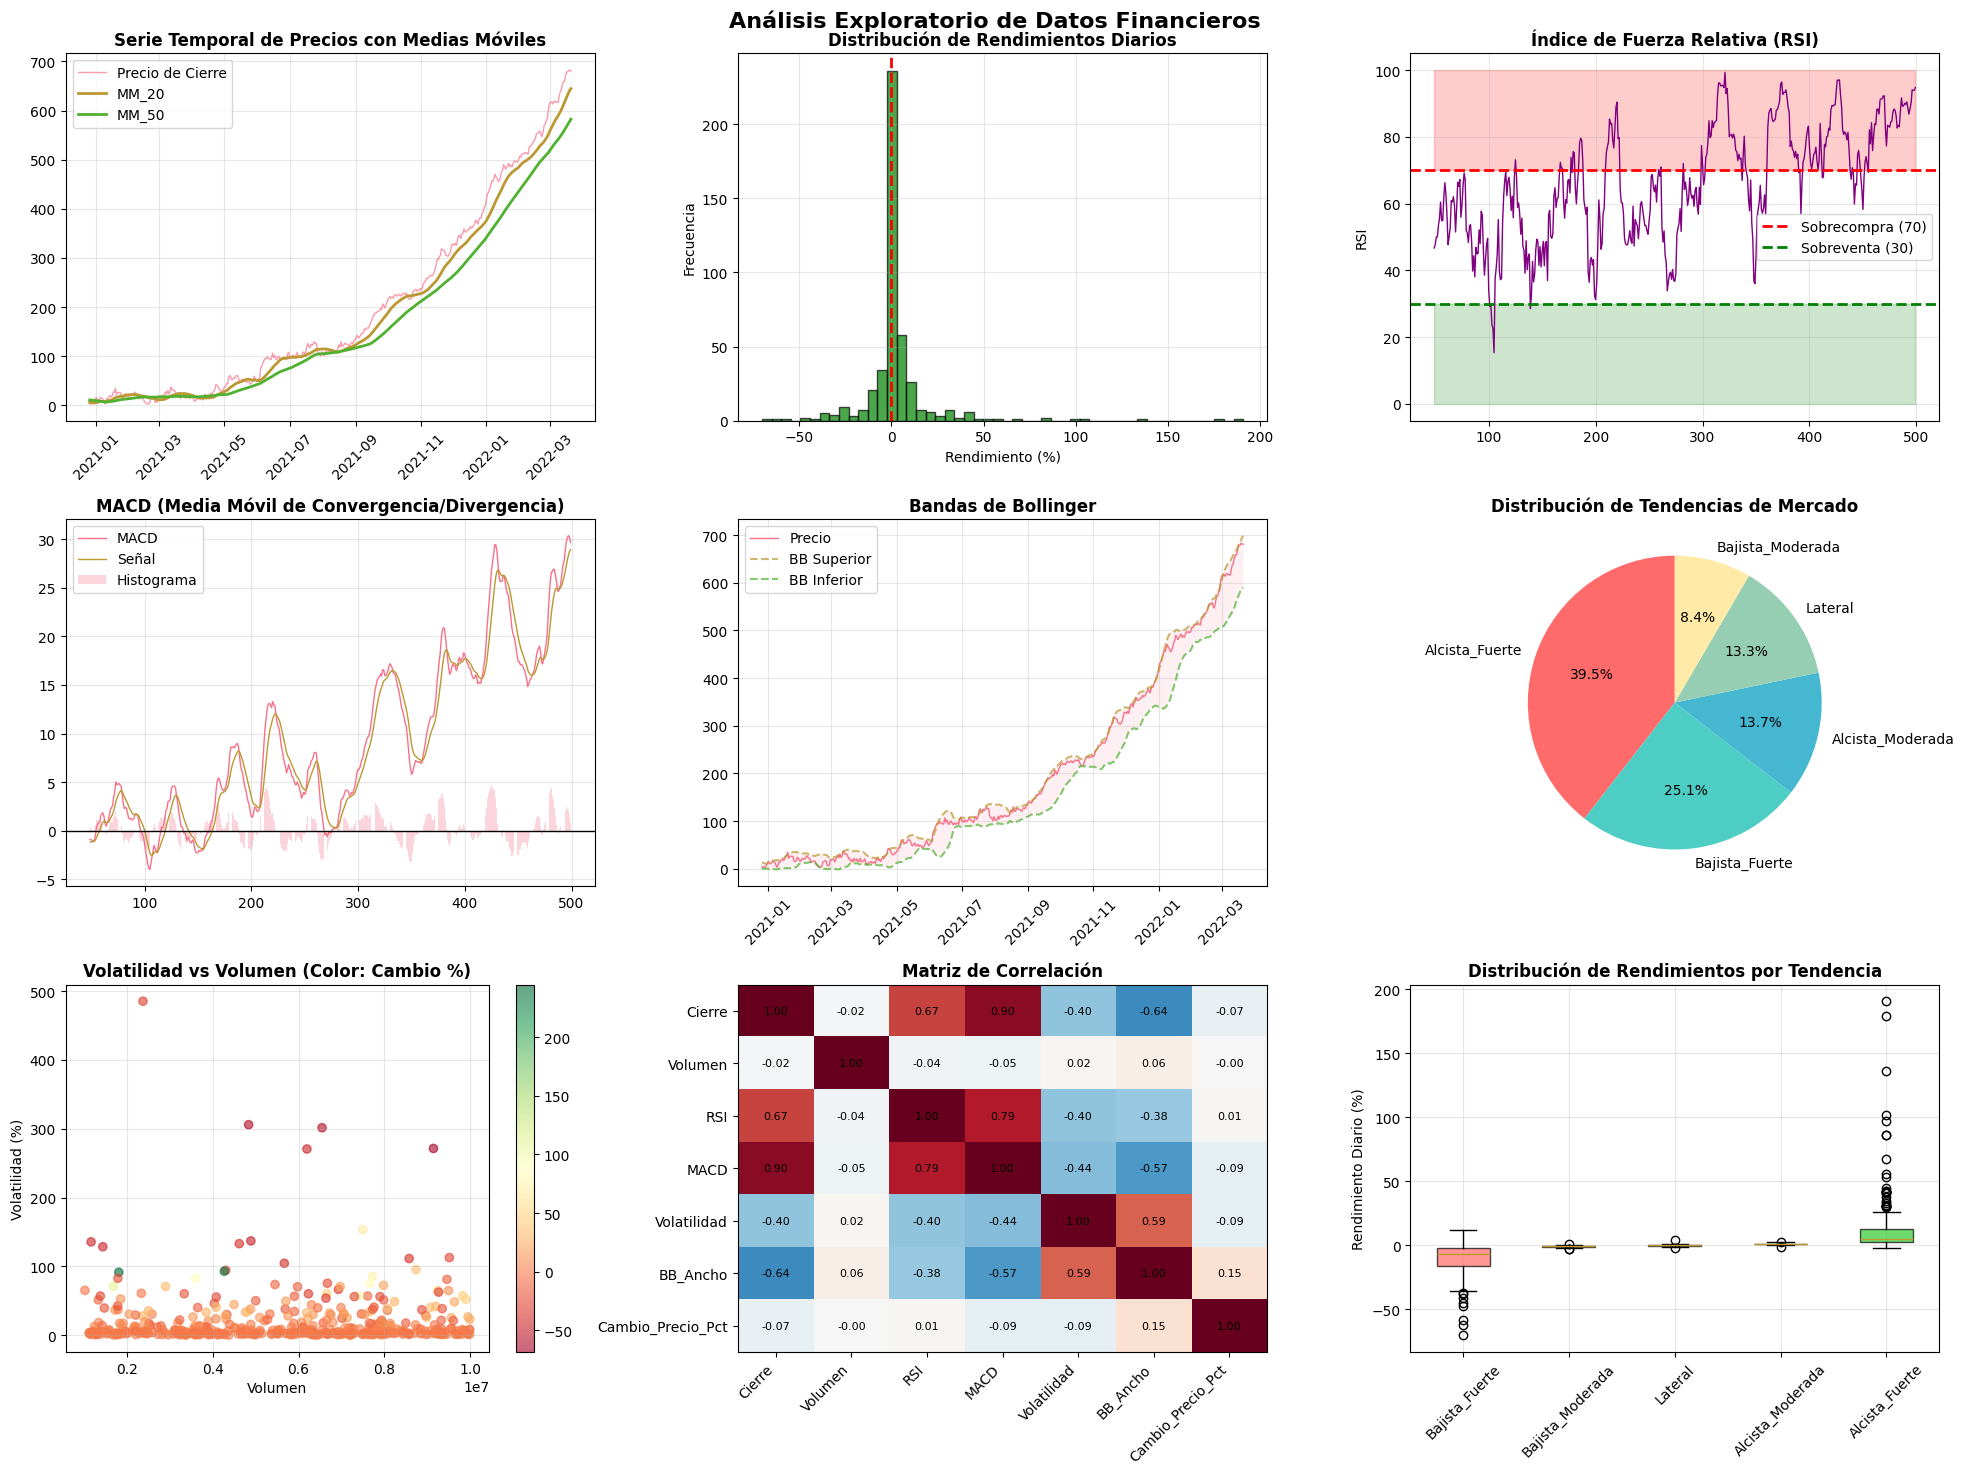


 ESTADÍSTICAS CLAVE:
   • Rendimiento promedio diario: 2.686%
   • Volatilidad promedio: 20.35%
   • RSI promedio: 66.1
   • Días con RSI > 70 (sobrecompra): 190 (42.1%)
   • Días con RSI < 30 (sobreventa): 6 (1.3%)

 CORRELACIONES DESTACADAS:
   • Mayor correlación: Cierre - MACD: 0.905
   • Segunda mayor: MACD - Cierre: 0.905


In [121]:
#  Análisis Exploratorio de Datos
def analisis_exploratorio_datos(datos):
    print(" ANÁLISIS EXPLORATORIO DE DATOS")


    #  Estadísticas descriptivas
    print("\n Estadísticas Descriptivas de Variables Clave:")
    variables_clave = ['Cierre', 'Volumen', 'RSI', 'MACD', 'Volatilidad', 'Cambio_Precio_Pct']
    print(datos[variables_clave].describe().round(2))

    #  Crear visualizaciones
    fig, ejes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Análisis Exploratorio de Datos Financieros', fontsize=16, fontweight='bold')

    # 1. Serie temporal de precios con medias móviles
    ejes[0, 0].plot(datos['Fecha'], datos['Cierre'], label='Precio de Cierre', alpha=0.7, linewidth=1)
    ejes[0, 0].plot(datos['Fecha'], datos['MM_20'], label='MM_20', linewidth=2)
    ejes[0, 0].plot(datos['Fecha'], datos['MM_50'], label='MM_50', linewidth=2)
    ejes[0, 0].set_title('Serie Temporal de Precios con Medias Móviles', fontweight='bold')
    ejes[0, 0].legend()
    ejes[0, 0].grid(True, alpha=0.3)
    ejes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Distribución de rendimientos diarios
    ejes[0, 1].hist(datos['Retorno_Diario'].dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
    ejes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    ejes[0, 1].set_title('Distribución de Rendimientos Diarios', fontweight='bold')
    ejes[0, 1].set_xlabel('Rendimiento (%)')
    ejes[0, 1].set_ylabel('Frecuencia')
    ejes[0, 1].grid(True, alpha=0.3)

    # 3. RSI con niveles de sobrecompra/sobreventa
    ejes[0, 2].plot(datos.index, datos['RSI'], color='purple', linewidth=1)
    ejes[0, 2].axhline(y=70, color='red', linestyle='--', label='Sobrecompra (70)', linewidth=2)
    ejes[0, 2].axhline(y=30, color='green', linestyle='--', label='Sobreventa (30)', linewidth=2)
    ejes[0, 2].fill_between(datos.index, 70, 100, alpha=0.2, color='red')
    ejes[0, 2].fill_between(datos.index, 0, 30, alpha=0.2, color='green')
    ejes[0, 2].set_title('Índice de Fuerza Relativa (RSI)', fontweight='bold')
    ejes[0, 2].set_ylabel('RSI')
    ejes[0, 2].legend()
    ejes[0, 2].grid(True, alpha=0.3)

    # 4. MACD
    ejes[1, 0].plot(datos.index, datos['MACD'], label='MACD', linewidth=1)
    ejes[1, 0].plot(datos.index, datos['MACD_Senal'], label='Señal', linewidth=1)
    ejes[1, 0].bar(datos.index, datos['MACD_Histograma'], label='Histograma', alpha=0.3)
    ejes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    ejes[1, 0].set_title('MACD (Media Móvil de Convergencia/Divergencia)', fontweight='bold')
    ejes[1, 0].legend()
    ejes[1, 0].grid(True, alpha=0.3)

    # 5. Bandas de Bollinger
    ejes[1, 1].plot(datos['Fecha'], datos['Cierre'], label='Precio', linewidth=1)
    ejes[1, 1].plot(datos['Fecha'], datos['BB_Superior'], label='BB Superior', linestyle='--', alpha=0.7)
    ejes[1, 1].plot(datos['Fecha'], datos['BB_Inferior'], label='BB Inferior', linestyle='--', alpha=0.7)
    ejes[1, 1].fill_between(datos['Fecha'], datos['BB_Inferior'], datos['BB_Superior'], alpha=0.1)
    ejes[1, 1].set_title('Bandas de Bollinger', fontweight='bold')
    ejes[1, 1].legend()
    ejes[1, 1].grid(True, alpha=0.3)
    ejes[1, 1].tick_params(axis='x', rotation=45)

    # 6. Distribución de tendencias de mercado
    conteo_tendencias = datos['Tendencia_Mercado'].value_counts()
    colores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    ejes[1, 2].pie(conteo_tendencias.values, labels=conteo_tendencias.index, autopct='%1.1f%%',
                   colors=colores, startangle=90)
    ejes[1, 2].set_title('Distribución de Tendencias de Mercado', fontweight='bold')

    # 7. Volatilidad vs Volumen
    scatter = ejes[2, 0].scatter(datos['Volumen'], datos['Volatilidad'],
                                c=datos['Cambio_Precio_Pct'], cmap='RdYlGn', alpha=0.6)
    ejes[2, 0].set_title('Volatilidad vs Volumen (Color: Cambio %)', fontweight='bold')
    ejes[2, 0].set_xlabel('Volumen')
    ejes[2, 0].set_ylabel('Volatilidad (%)')
    ejes[2, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ejes[2, 0])

    # 8. Matriz de correlación
    variables_corr = ['Cierre', 'Volumen', 'RSI', 'MACD', 'Volatilidad', 'BB_Ancho', 'Cambio_Precio_Pct']
    matriz_corr = datos[variables_corr].corr()
    im = ejes[2, 1].imshow(matriz_corr, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    ejes[2, 1].set_xticks(range(len(variables_corr)))
    ejes[2, 1].set_yticks(range(len(variables_corr)))
    ejes[2, 1].set_xticklabels(variables_corr, rotation=45, ha='right')
    ejes[2, 1].set_yticklabels(variables_corr)
    ejes[2, 1].set_title('Matriz de Correlación', fontweight='bold')

    # Añadir valores numéricos a la matriz
    for i in range(len(variables_corr)):
        for j in range(len(variables_corr)):
            ejes[2, 1].text(j, i, f'{matriz_corr.iloc[i, j]:.2f}',
                           ha='center', va='center', fontsize=8)

    # 9. Boxplot de rendimientos según tendencia
    orden_tendencias = ['Bajista_Fuerte', 'Bajista_Moderada', 'Lateral', 'Alcista_Moderada', 'Alcista_Fuerte']
    datos_box = [datos[datos['Tendencia_Mercado'] == tendencia]['Retorno_Diario'].dropna()
                 for tendencia in orden_tendencias if tendencia in datos['Tendencia_Mercado'].unique()]
    etiquetas_box = [tendencia for tendencia in orden_tendencias if tendencia in datos['Tendencia_Mercado'].unique()]

    box = ejes[2, 2].boxplot(datos_box, labels=etiquetas_box, patch_artist=True)
    colores_box = ['#FF6B6B', '#FFB347', '#FFFF99', '#90EE90', '#32CD32']
    for patch, color in zip(box['boxes'], colores_box[:len(box['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ejes[2, 2].set_title('Distribución de Rendimientos por Tendencia', fontweight='bold')
    ejes[2, 2].set_ylabel('Rendimiento Diario (%)')
    ejes[2, 2].tick_params(axis='x', rotation=45)
    ejes[2, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    #  Estadísticas adicionales
    print(f"\n ESTADÍSTICAS CLAVE:")
    print(f"   • Rendimiento promedio diario: {datos['Retorno_Diario'].mean():.3f}%")
    print(f"   • Volatilidad promedio: {datos['Volatilidad'].mean():.2f}%")
    print(f"   • RSI promedio: {datos['RSI'].mean():.1f}")
    print(f"   • Días con RSI > 70 (sobrecompra): {(datos['RSI'] > 70).sum()} ({(datos['RSI'] > 70).mean()*100:.1f}%)")
    print(f"   • Días con RSI < 30 (sobreventa): {(datos['RSI'] < 30).sum()} ({(datos['RSI'] < 30).mean()*100:.1f}%)")

    #  Correlaciones destacadas
    print(f"\n CORRELACIONES DESTACADAS:")
    correlaciones_altas = matriz_corr.abs().unstack().sort_values(ascending=False)
    correlaciones_altas = correlaciones_altas[correlaciones_altas < 1.0]  # Excluir auto-correlaciones
    print(f"   • Mayor correlación: {correlaciones_altas.index[0][0]} - {correlaciones_altas.index[0][1]}: {correlaciones_altas.iloc[0]:.3f}")
    print(f"   • Segunda mayor: {correlaciones_altas.index[1][0]} - {correlaciones_altas.index[1][1]}: {correlaciones_altas.iloc[1]:.3f}")

#  Aplicar el preprocesamiento
print(" Calculando indicadores técnicos...")
datos_procesados = calculate_technical_indicators(datos_restaurant)

#  Eliminar filas con valores NaN
datos_procesados = datos_procesados.dropna()

print(" Indicadores técnicos calculados")
print(f" Datos procesados: {len(datos_procesados)} registros")
print(f" Columnas totales: {len(datos_procesados.columns)}")

# 👉 Ejecutar el análisis exploratorio
analisis_exploratorio_datos(datos_procesados)

In [122]:
# 📌 Modelos de Machine Learning para Clasificación

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



def implementar_modelos_ml(datos):
    print("🤖 IMPLEMENTACIÓN DE MODELOS DE MACHINE LEARNING")
    print("="*60)

    # Seleccionar variables predictoras en español
    columnas_features = [
        'Cierre', 'Volumen', 'RSI', 'MACD', 'MACD_Senal', 'MACD_Histograma',
        'Bandas_Ancho', 'Volatilidad', 'MM_5', 'MM_10', 'MM_20', 'MM_50',
        'Cambio_Precio_Pct', 'Retorno_Diario', 'Rango_Verdadero',
        'PER', 'Rendimiento_Dividendo'
    ]

    # Variables de entrada (X) y salida (y)
    X = datos[columnas_features].copy()
    y = datos['Tendencia_Mercado'].copy()

    # Manejo de valores infinitos o nulos
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())

    print(f"📊 Features utilizadas: {len(columnas_features)}")
    print(f"🎯 Variable objetivo: Tendencia_Mercado")

    # Codificar variable objetivo
    codificador = LabelEncoder()
    y_codificado = codificador.fit_transform(y)

    # Escalar datos
    escalador = StandardScaler()
    X_escalado = escalador.fit_transform(X)

    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_escalado, y_codificado, test_size=0.2, stratify=y_codificado, random_state=42
    )

    # Definir modelos
    modelos = {
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
        "SVM": SVC(kernel='rbf', probability=True, random_state=42),
        "Naive Bayes": GaussianNB(),
        "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42)
    }

    resultados = {}

    for nombre, modelo in modelos.items():
        print(f"\n🔹 Entrenando modelo: {nombre}")
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"   ✅ Precisión en test: {acc:.3f}")
        resultados[nombre] = acc

    # 📊 Comparar modelos
    plt.figure(figsize=(8,5))
    plt.bar(resultados.keys(), resultados.values(), color="skyblue")
    plt.ylabel("Precisión")
    plt.title("Comparación de Modelos de ML")
    plt.xticks(rotation=30)
    plt.show()

    return resultados


In [123]:
###### nltk.download('punkt_tab')
###### Descargar recursos necesarios (solo la primera vez)
###### nltk.download('vader_lexicon')
###### nltk.download('punkt')
###### nltk.download('stopwords')

In [124]:
# ============================
# 📊 ANÁLISIS DE REPORTES FINANCIEROS (ESPAÑOL)
# ============================

# 📦 Librerías necesarias
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from textblob import TextBlob

# 📄 Reportes financieros en español
financial_reports = [
    "La empresa reportó sólidas ganancias trimestrales con un crecimiento de ingresos del 15% interanual. Los márgenes de ganancia aumentaron gracias a mejoras en la eficiencia operativa.",
    "La volatilidad del mercado continúa generando incertidumbre para los inversores. Los vientos económicos en contra y las preocupaciones por la inflación afectan las proyecciones futuras.",
    "Desempeño excepcional en el tercer trimestre con ventas récord. La gerencia se muestra optimista respecto a los planes de expansión y la posición en el mercado.",
    "Los desafíos regulatorios y el aumento de la competencia representan riesgos significativos para la rentabilidad. Se están implementando medidas de reducción de costos.",
    "La innovación en inteligencia artificial y servicios en la nube impulsa un fuerte crecimiento de ingresos. El sólido balance respalda inversiones estratégicas.",
    "La caída en la demanda del consumidor y las interrupciones en la cadena de suministro afectan los resultados trimestrales. La gerencia pronostica condiciones desafiantes hacia adelante.",
    "El lanzamiento de un producto innovador superó las expectativas, aumentando la confianza de los inversionistas. Se lograron ganancias de mercado en segmentos clave.",
    "Los costos de acuerdos legales y de cumplimiento generan una carga financiera. Se están llevando a cabo esfuerzos de reestructuración para mejorar la eficiencia operativa.",
    "Los acuerdos de asociación y adquisiciones estratégicas posicionan a la empresa para un crecimiento a largo plazo. Las fuentes de ingresos diversificadas reducen el riesgo.",
    "Incidentes de ciberseguridad y filtraciones de datos generan preocupación sobre la resiliencia operativa. Se anunció inversión en infraestructura de seguridad.",
    "El aumento del dividendo refleja una fuerte generación de flujo de caja y compromiso con los accionistas. El programa de recompra de acciones demuestra confianza.",
    "Las tensiones comerciales y fluctuaciones de divisas afectan las operaciones internacionales. Se implementaron estrategias de cobertura para mitigar riesgos.",
    "Las iniciativas de transformación digital muestran resultados prometedores con una mejor interacción con clientes y métricas operativas.",
    "Las regulaciones ambientales y requisitos de sostenibilidad aumentan los costos de cumplimiento, pero se alinean con las tendencias de inversión ESG.",
    "La finalización de la fusión crea sinergias y una mayor presencia en el mercado. Se esperan desafíos de integración en el corto plazo."
]

# 🗂️ Metadatos de ejemplo
report_metadata = [
    {"sector": "Tecnología", "trimestre": "Q2", "año": 2024},
    {"sector": "Finanzas", "trimestre": "Q1", "año": 2024},
    {"sector": "Retail", "trimestre": "Q3", "año": 2024},
    {"sector": "Salud", "trimestre": "Q1", "año": 2024},
    {"sector": "Tecnología", "trimestre": "Q4", "año": 2023},
    {"sector": "Manufactura", "trimestre": "Q2", "año": 2024},
    {"sector": "Consumo", "trimestre": "Q3", "año": 2024},
    {"sector": "Energía", "trimestre": "Q1", "año": 2024},
    {"sector": "Finanzas", "trimestre": "Q4", "año": 2023},
    {"sector": "Tecnología", "trimestre": "Q2", "año": 2024},
    {"sector": "Servicios Públicos", "trimestre": "Q3", "año": 2024},
    {"sector": "Manufactura", "trimestre": "Q1", "año": 2024},
    {"sector": "Retail", "trimestre": "Q2", "año": 2024},
    {"sector": "Energía", "trimestre": "Q3", "año": 2024},
    {"sector": "Salud", "trimestre": "Q4", "año": 2023}
]

print(f"📄 Analizando {len(financial_reports)} reportes financieros...\n")

# 🧠 Análisis de sentimientos
sentiment_results = []

for i, report in enumerate(financial_reports):
    blob = TextBlob(report)
    polarity = blob.sentiment.polarity  # entre -1 y 1

    if polarity > 0.05:
        sentiment_class = "Positivo"
    elif polarity < -0.05:
        sentiment_class = "Negativo"
    else:
        sentiment_class = "Neutral"

    result = {
        "id_reporte": i + 1,
        "texto_preview": report[:100] + "...",
        "sentimiento": sentiment_class,
        "polaridad": round(polarity, 3),
        "cantidad_palabras": len(report.split()),
        "sector": report_metadata[i]["sector"],
        "trimestre": report_metadata[i]["trimestre"],
        "año": report_metadata[i]["año"]
    }
    sentiment_results.append(result)

sentiment_df = pd.DataFrame(sentiment_results)

# 🔑 Función para extraer palabras clave
def extract_keywords(texts, top_n=20):
    all_words = []
    stop_words = set(stopwords.words("spanish"))
    extra_stopwords = {
        "empresa", "mercado", "trimestre", "año", "resultados", "informe", "financiero"
    }
    stop_words.update(extra_stopwords)

    for text in texts:
        words = re.findall(r'\b[a-záéíóúñ]{3,}\b', text.lower())
        words = [word for word in words if word not in stop_words]
        all_words.extend(words)

    return Counter(all_words).most_common(top_n)

keywords = extract_keywords(financial_reports)

# 📊 Resultados finales
print("📊 ESTADÍSTICAS DEL ANÁLISIS NLP:")
print("="*40)
print(f"   • Reportes analizados: {len(sentiment_df)}")
print(f"   • Polaridad promedio: {sentiment_df['polaridad'].mean():.3f}")
print(f"   • Reportes positivos: {(sentiment_df['sentimiento'] == 'Positivo').sum()}")
print(f"   • Reportes negativos: {(sentiment_df['sentimiento'] == 'Negativo').sum()}")
print(f"   • Reportes neutrales: {(sentiment_df['sentimiento'] == 'Neutral').sum()}")
print(f"   • Palabras clave únicas identificadas: {len(keywords)}")

print("\n🔑 Palabras clave más frecuentes:")
for palabra, freq in keywords:
    print(f"   - {palabra}: {freq}")


📄 Analizando 15 reportes financieros...

📊 ESTADÍSTICAS DEL ANÁLISIS NLP:
   • Reportes analizados: 15
   • Polaridad promedio: -0.040
   • Reportes positivos: 0
   • Reportes negativos: 1
   • Reportes neutrales: 14
   • Palabras clave únicas identificadas: 20

🔑 Palabras clave más frecuentes:
   - crecimiento: 3
   - ingresos: 3
   - operativa: 3
   - afectan: 3
   - costos: 3
   - ganancias: 2
   - trimestrales: 2
   - eficiencia: 2
   - gerencia: 2
   - desafíos: 2
   - aumento: 2
   - riesgos: 2
   - fuerte: 2
   - estratégicas: 2
   - confianza: 2
   - acuerdos: 2
   - cumplimiento: 2
   - generan: 2
   - plazo: 2
   - inversión: 2


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4102 - loss: 1.5884 - val_accuracy: 0.2135 - val_loss: 1.7710
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4620 - loss: 1.4348 - val_accuracy: 0.2135 - val_loss: 1.9530
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4379 - loss: 1.3336 - val_accuracy: 0.3933 - val_loss: 1.4765
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4120 - loss: 1.2878 - val_accuracy: 0.3483 - val_loss: 1.4487
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4320 - loss: 1.2506 - val_accuracy: 0.3483 - val_loss: 1.4262
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4236 - loss: 1.1719 - val_accuracy: 0.3483 - val_loss: 1.4213
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3877 - loss: 1.2812 - val_accuracy: 0.3483 - val_loss: 1.4217
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4482 - loss: 1.2627 - val_accuracy: 0.3483 - val_lo

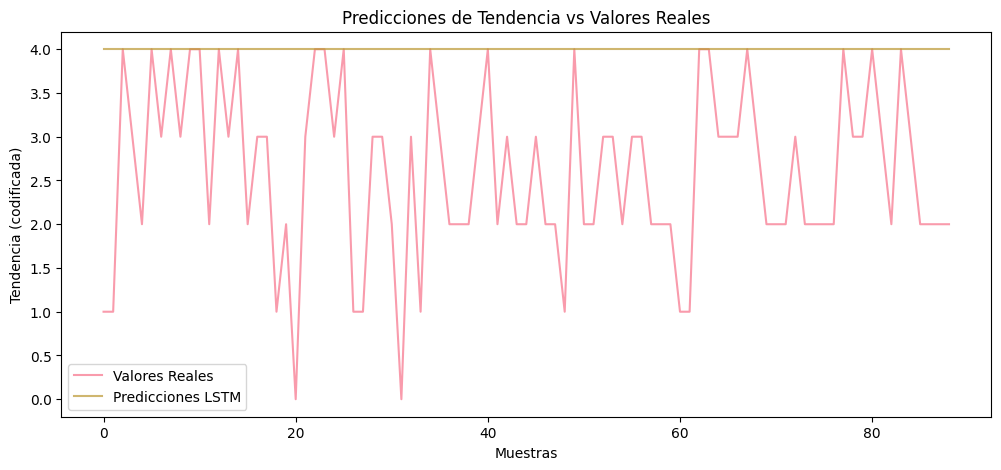

In [125]:
# ============================
# 🔹 Red Neuronal LSTM para Tendencias de Mercado
# ============================

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Selección de columna de precios
datos_lstm = processed_data[['Cierre', 'Tendencia_Mercado']].copy()

# Escalar precios
scaler = MinMaxScaler(feature_range=(0,1))
datos_lstm['Cierre_Scaled'] = scaler.fit_transform(datos_lstm[['Cierre']])

# Codificar tendencias como números
tendencia_map = {
    'Bajista_Fuerte':0,
    'Bajista_Moderada':1,
    'Lateral':2,
    'Alcista_Moderada':3,
    'Alcista_Fuerte':4
}
datos_lstm['Tendencia_Num'] = datos_lstm['Tendencia_Mercado'].map(tendencia_map)

# Crear secuencias para LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data['Cierre_Scaled'].values[i-seq_length:i])
        y.append(data['Tendencia_Num'].values[i])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
X, y = create_sequences(datos_lstm, SEQ_LENGTH)

# Dividir en train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Dar forma a LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construir modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(5, activation='softmax')  # 5 clases de tendencias
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluación
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 Precisión del LSTM en test: {acc:.3f}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Graficar predicciones vs reales
plt.figure(figsize=(12,5))
plt.plot(y_test, label='Valores Reales', alpha=0.7)
plt.plot(y_pred_classes, label='Predicciones LSTM', alpha=0.7)
plt.title('Predicciones de Tendencia vs Valores Reales')
plt.xlabel('Muestras')
plt.ylabel('Tendencia (codificada)')
plt.legend()
plt.show()
